In [1]:
import secrets

# import easydict
import matplotlib.pyplot as plt
import torch
# from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import torch.utils.data as data
from tqdm import tqdm
import pandas as pd
import numpy as np

# from model import LSTMVAE
from numpy import recarray
from sklearn.model_selection import train_test_split
from torchvision import transforms
import torch.utils.data as data
import os

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch
from torch import nn
from torch.nn import functional as F
import os
from torch.nn.utils.rnn import pad_sequence
import copy

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

# if torch.cuda.is_available():
#     device = 'cuda'
#     print('on cuda')
# else:
#     device = 'cpu'
#     print('on cpu')
device = 'cpu'

In [2]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

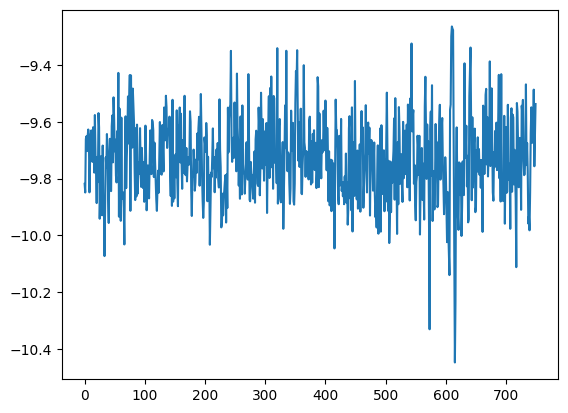

In [3]:
dataset_path = '/home/jm/vscode/Python/pythonenv/gait-project/datasets/MHEALTHDATASET_CSV/mHealth_subject1.csv'

dataset = pd.read_csv(dataset_path)
dataset = dataset['chest acceleration X-axis']
plt.plot(dataset[:750])


## labels: 

* L0: NULL Class
* L1: Standing still (1 min)
* L2: Sitting and relaxing (1 min)
* L3: Lying down (1 min)
* L4: Walking (1 min)
* L5: Climbing stairs (1 min)
* L6: Waist bends forward (20x)
* L7: Frontal elevation of arms (20x)
* L8: Knees bending (crouching) (20x)
* L9: Cycling (1 min)
* L10: Jogging (1 min)
* L11: Running (1 min)
* L12: Jump front & back (20x)

In [4]:
# cwd = os.getcwd() + "/MHEALTHDATASET_CSV"

cwd = '/home/jm/vscode/Python/pythonenv/gait-project/datasets/MHEALTHDATASET_CSV'

print(cwd)

os.chdir(cwd)

/home/jm/vscode/Python/pythonenv/gait-project/datasets/MHEALTHDATASET_CSV


In [5]:
#split data into sections by label

df = pd.DataFrame()
dataframes = []
for file in os.listdir():
    if file.endswith(".csv"):
        file_path = f"{cwd}/{file}"
        temp = pd.read_csv(file_path)
        dataframes.append(temp)
        print('file:', file, '| size = ', len(temp))
        
df = pd.concat(dataframes)

file: mHealth_subject1.csv | size =  161280
file: mHealth_subject10.csv | size =  98304
file: mHealth_subject2.csv | size =  130561
file: mHealth_subject3.csv | size =  122112
file: mHealth_subject4.csv | size =  116736
file: mHealth_subject5.csv | size =  119808
file: mHealth_subject6.csv | size =  98304
file: mHealth_subject7.csv | size =  104448
file: mHealth_subject8.csv | size =  129024
file: mHealth_subject9.csv | size =  135168


In [6]:
#extracts x,y,z chest accel data into different label groups
def partition_data(label, dataframe):
    x_data = []
    y_data = []
    z_data = []
    activity = []
    
    for i in range(len(dataframe)):
        if(df['label'].iloc[i] == label):
            x_data.append(df['chest acceleration X-axis'].iloc[i])
            y_data.append(df['chest acceleration Y-axis'].iloc[i])
            z_data.append(df['chest acceleration Z-axis'].iloc[i])
            activity.append(df['label'].iloc[i])
            
    
    partitioned_df = pd.DataFrame(
                                  {
        'x-axis': x_data,
        'y-axis': y_data,
        'z-axis': z_data,
        'label': activity
                                  })
    
    return partitioned_df

In [7]:
# temp = partition_data(0, df)
# print(temp)

In [8]:
# #splitting all mhealth data based on label, used for classification
# df_null = partition_data(0, df)
# df_stand = partition_data(1, df) 
# df_sit = partition_data(2, df)
# df_lying = partition_data(3, df)
# df_walk = partition_data(4, df)
# df_stairs = partition_data(5, df)
# df_waist_bend = partition_data(6, df)
# df_arms = partition_data(7, df) 
# df_knee_bend = partition_data(8, df) 
# df_cycle = partition_data(9, df) 
# df_jog = partition_data(10, df) 
# df_run = partition_data(11, df) 
# df_jump = partition_data(12, df) 

In [9]:
class mHealth(data.Dataset):

    def __init__(self, dataframe):
        """
        Args:
            csv_file (string): path to csv file with data
        """
        self.dataset = dataframe

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        """
        Args:
            index (int): index

        Returns:
            (sequence, [128, 3])
            returns the time series data of length 128 
            (X-axis, Y-axis, Z-axis)
        """
        #return sequence of length 128 x 3
        sequence = torch.tensor(self.dataset[index:index+128].to_numpy()).type(torch.float32) 

        return sequence

def collate_fn(data):
    inputs = [torch.tensor(d) for d in data]

    inputs = pad_sequence(inputs, batch_first=True)

    return inputs

In [10]:
sub_1_df = pd.read_csv('/home/jm/vscode/Python/pythonenv/gait-project/datasets/MHEALTHDATASET_CSV/mHealth_subject1.csv')
sub_1_df = sub_1_df.drop(df.columns[3:24], axis=1) #drop all columns that aren't chest accel info

train_df, val_df = train_test_split(
  sub_1_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)
sub_1_df

,chest acceleration X-axis,chest acceleration Y-axis,chest acceleration Z-axis
0,-9.8184,0.009971,0.29563
1,-9.8489,0.524040,0.37348
2,-9.6602,0.181850,0.43742
3,-9.6507,0.214220,0.24033
4,-9.7030,0.303890,0.31156
...,...,...,...
161275,-9.4032,0.464170,-3.29510
161276,-9.5201,0.751360,-3.84820
161277,-9.3682,1.239600,-3.02530
161278,-8.6702,1.185900,-3.01960


In [11]:
split_idx = int(len(sub_1_df) * 0.8)

train_set = mHealth(
    dataframe=sub_1_df[:split_idx],
)

test_set = mHealth(
    dataframe=sub_1_df[split_idx:],
)

batch_size = 512
input_size = 4
hidden_size = 128
latent_size = 16
num_layers = 2

In [12]:
print(train_set[124].shape)

torch.Size([128, 3])


In [13]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True
)

print(f"Dataloaders: {train_loader}")
print(f"Length of train_dataloader: {len(train_loader)} batches of {batch_size}")


for idx, data in enumerate(train_loader):

    print(data.shape)
    
    break
    print("Data shape:", datas.shape)
    #print("Labels:", labels)
   # ("Labels shape:", len(labels))
    print("labels shape", labels.shape)
    break



Dataloaders: <torch.utils.data.dataloader.DataLoader object at 0x77bad8fcce00>
Length of train_dataloader: 252 batches of 512
torch.Size([512, 128, 3])


/tmp/ipykernel_57462/208133306.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


In [14]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
    print("hidden size: ", self.hidden_dim)
    
    self.rnn1 = nn.LSTM(
      input_size=n_features * 16,
      hidden_size=self.hidden_dim,
      # output_size=self.embedding_dim,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim*3,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len * 32, self.n_features * 16))
    print("seq len: ", self.seq_len)
    print("feat: ", self.n_features)
    print("x shape", x.shape)
    
    x, (_, _) = self.rnn1(x)
    print("x shape rnn1", x.shape)
    x, (hidden_n, _) = self.rnn2(x)
    print("hiddenn shape: ", hidden_n.shape)
    print("x shape rnn2", x.shape)
    print("feat ", self.n_features, self.embedding_dim)
    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [15]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=3):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim * 3,
      hidden_size=input_dim * 16,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim * 16,
      hidden_size=self.hidden_dim * 32,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn3 = nn.LSTM(
      input_size=self.hidden_dim * 32,
      hidden_size= 16384,
      num_layers=1,
      batch_first=True
    )
    

    self.output_layer = nn.Linear(int(self.input_dim/2)*3, n_features) #[96 -> 3]

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim * 3))
    print("decoder xshape pre rnn: ", x.shape)
    x, (hidden_n, cell_n) = self.rnn1(x)
    print("decoder xshape rnn1: ", x.shape)
    x, (hidden_n, cell_n) = self.rnn2(x)
    print("decoder xshape rnn2: ", x.shape)
    x, (hidden_n, cell_n) = self.rnn3(x)
    print("input dim: ", int(self.input_dim/2)*3)
    x = x.reshape((512, self.seq_len, int(self.input_dim/2)*3))
  
    print("decoder xshape: ", x.shape)
    x = self.output_layer(x)
    print("reconstruction xshape: ", x.shape)
    return x

In [16]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [17]:
model = RecurrentAutoencoder(128, 3, 64)
model = model.to(device)

hidden size:  128


In [18]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)
      
      print("seq_true shape: ", seq_true.shape)
      print("seq_pred shape: ", seq_pred)
      
      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [19]:
model, history = train_model(
  model, 
  train_loader, 
  test_loader, 
  n_epochs=150
)

/tmp/ipykernel_57462/208133306.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


seq len:  128
feat:  3
x shape torch.Size([1, 4096, 48])
x shape rnn1 torch.Size([1, 4096, 128])
hiddenn shape:  torch.Size([1, 1, 192])
x shape rnn2 torch.Size([1, 4096, 192])
feat  3 64
decoder xshape pre rnn:  torch.Size([3, 128, 192])
decoder xshape rnn1:  torch.Size([3, 128, 1024])
decoder xshape rnn2:  torch.Size([3, 128, 4096])
input dim:  96
decoder xshape:  torch.Size([512, 128, 96])
reconstruction xshape:  torch.Size([512, 128, 3])
seq_true shape:  torch.Size([512, 128, 3])
seq_pred shape:  tensor([[[-0.0493,  0.0295, -0.0601],
         [-0.0506,  0.0273, -0.0601],
         [-0.0504,  0.0271, -0.0598],
         ...,
         [-0.0494,  0.0267, -0.0604],
         [-0.0506,  0.0268, -0.0593],
         [-0.0502,  0.0270, -0.0613]],

        [[-0.0490,  0.0270, -0.0595],
         [-0.0489,  0.0263, -0.0608],
         [-0.0504,  0.0277, -0.0612],
         ...,
         [-0.0481,  0.0277, -0.0617],
         [-0.0475,  0.0271, -0.0607],
         [-0.0494,  0.0265, -0.0631]],

      

/home/jm/vscode/Python/pythonenv/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


seq len:  128
feat:  3
x shape torch.Size([1, 4096, 48])
x shape rnn1 torch.Size([1, 4096, 128])
hiddenn shape:  torch.Size([1, 1, 192])
x shape rnn2 torch.Size([1, 4096, 192])
feat  3 64
decoder xshape pre rnn:  torch.Size([3, 128, 192])
decoder xshape rnn1:  torch.Size([3, 128, 1024])
decoder xshape rnn2:  torch.Size([3, 128, 4096])
input dim:  96
decoder xshape:  torch.Size([512, 128, 96])
reconstruction xshape:  torch.Size([512, 128, 3])
seq_true shape:  torch.Size([512, 128, 3])
seq_pred shape:  tensor([[[-56.9939,  15.1429,   9.6926],
         [-56.9945,  15.1405,   9.6923],
         [-56.9941,  15.1410,   9.6933],
         ...,
         [-56.9929,  15.1420,   9.6934],
         [-56.9938,  15.1406,   9.6935],
         [-56.9936,  15.1404,   9.6910]],

        [[-56.9931,  15.1412,   9.6929],
         [-56.9930,  15.1416,   9.6926],
         [-56.9947,  15.1428,   9.6911],
         ...,
         [-56.9959,  15.1416,   9.6927],
         [-56.9955,  15.1422,   9.6922],
         [-56

In [ ]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

In [ ]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);